In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time as ct
import random

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline

### Dowloading sample data

In [2]:
pen = sns.load_dataset('penguins')
# pen = pd.read_csv('https://raw.githubusercontent.com/seaborn/seaborn-data/master/penguins.csv')

In [3]:
pen.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
236,Gentoo,Biscoe,42.0,13.5,210.0,4150.0,Female
46,Adelie,Dream,41.1,19.0,182.0,3425.0,Male
266,Gentoo,Biscoe,45.5,13.9,210.0,4200.0,Female
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
259,Gentoo,Biscoe,48.7,15.7,208.0,5350.0,Male


In [4]:
pen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
pen.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [6]:
# to get all object columns from our dataset
def obj_cols(df):
    '''
    This function returns the object columns in a given dataframe
    Parameters:
    	df (Pandas dataframe) : The dataframe in which to search for object columns

    Returns:
    	List of Object columns
    '''
    object_cols = df.select_dtypes(include = ['object']).columns
    if object_cols.shape[0]>0 : 
        print('Count of object columns: {}'.format(object_cols.shape[0]))
        return list(object_cols.values)
    else:
        print('No object columns in the dataframe!')
        return

In [7]:
obj_cols(pen)

Count of object columns: 3


['species', 'island', 'sex']

## Missing Data Report

In [8]:
def dataframe_null_report(df=None,null_pct_threshold=0):
    '''
    This function returns the fraction of nulls in each column of the dataframe based on a threshold specified as a fraction
    Parameters:
    	df (Pandas dataframe) : The dataframe for which you want to check the null % for each of its columns
    	null_pct_threshold (numeric) : Between 0 to 1. This is the minimum threshold on fraction nulls that wil be returned.
    									If no threshold is specified then it shows all columns with even in a single null.
    									Example: If 0.1 is specified then the function will return all columns which have >10% nulls.
    Returns:
    	Dataframe with all columns as rows which have fraction of nulls above the 'null_pct_threshold' with their % nulls value
    '''
    null_pct_df = pd.DataFrame(df.isna().sum(axis = 0)).reset_index()
    null_pct_df.columns = ['Variable','NullCount']
    null_pct_df['NullCountPct'] = null_pct_df['NullCount']/df.shape[0]
    null_pct_df.sort_values('NullCountPct',ascending=False,inplace=True)
    total_columns = df.shape[1]
    null_pct_df = null_pct_df[null_pct_df['NullCountPct']>null_pct_threshold]
    columns_with_10pct_nulls = null_pct_df.shape[0]
    print('Total Columns in Dataframe: {}'.format(total_columns))
    print('Columns with >{}% Nulls: {}'.format(null_pct_threshold*100,columns_with_10pct_nulls))
    return null_pct_df

In [9]:
dataframe_null_report(pen)

Total Columns in Dataframe: 7
Columns with >0% Nulls: 5


,Variable,NullCount,NullCountPct
6,sex,11,0.031977
2,bill_length_mm,2,0.005814
3,bill_depth_mm,2,0.005814
4,flipper_length_mm,2,0.005814
5,body_mass_g,2,0.005814


## Univariate Exploration
### Categorical column distribution

In [10]:
def cat_dist(df=None,var_name='',plot=True,viz='Bar',cat_limit=5):
    '''
    This function shows the distribution () of any variable and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : String, Name of the variable for which the distribution should be shown
        plot          : Boolean, Default True; Will plot a bar/pie chart showing the distribution if set to True
        viz           : Default will be bar chart, can also show pie chart
        limit_cat     : In case of multiple categories, the top 5 categories will be shown by default
    '''
    tot_count = df.shape[0]
    cat_df = pd.DataFrame(df[var_name].value_counts()).reset_index().rename(columns = {'index':'Category',var_name:'Frequency'})
    cat_df.sort_values(by='Frequency', ascending=False,inplace=True,ignore_index=True)
    cat_n = cat_df.shape[0]
    if cat_n>cat_limit:
        other_df = cat_df.iloc[cat_limit:]
        other_df = other_df.sum()
        cat_df.iloc[cat_limit] = ['Others', other_df[1]] 
        cat_df = cat_df[:cat_limit+1]
    cat_df['Percentage'] = cat_df['Frequency']/tot_count
    cat_df['Percentage'] = pd.Series(["{0:.1f}%".format(round(val*100,1)) for val in cat_df['Percentage']], index = cat_df.index)
    
    #Visualization
    if plot == True:
        #sub function to format labels
        def autopct_format(values):
            def my_format(pct):
                total = sum(values)
                val = int(round(pct*total/100.0))
                return '{:.1f}%\n({v:d})'.format(pct, v=val)
            return my_format
        if viz == 'Bar':
            plt.figure(figsize=(20,8))
            sns.set_theme(style="darkgrid")
            ax = sns.barplot(data=cat_df, x='Category', y="Frequency")
            ax.set(xlabel = var_name, ylabel = 'Frequency')
            x_labels = cat_df['Category']
            title = 'Frequency Distribution of '+var_name
            ax.set_xticklabels(x_labels)
            ax.set_title(title, y=1.03, fontsize=18)
            #ax.bar_label(ax.containers[-1],autopct_format(cat_df['Frequency']), label_type='center')
            for p in ax.patches:
                ax.annotate('{}\n({:.1f}%)'.format(p.get_height().astype(int),p.get_height()/tot_count*100), (p.get_x(), p.get_height()+1))
        elif viz == 'Pie':
            plt.figure(figsize=(10,8))
            colors = sns.color_palette('pastel')
            plt.pie(cat_df['Frequency'], labels = cat_df['Category'], colors = colors, autopct=autopct_format(cat_df['Frequency']))
            title = 'Distribution of '+var_name
    return cat_df

,Category,Frequency,Percentage
0,Biscoe,168,48.8%
1,Dream,124,36.0%
2,Torgersen,52,15.1%


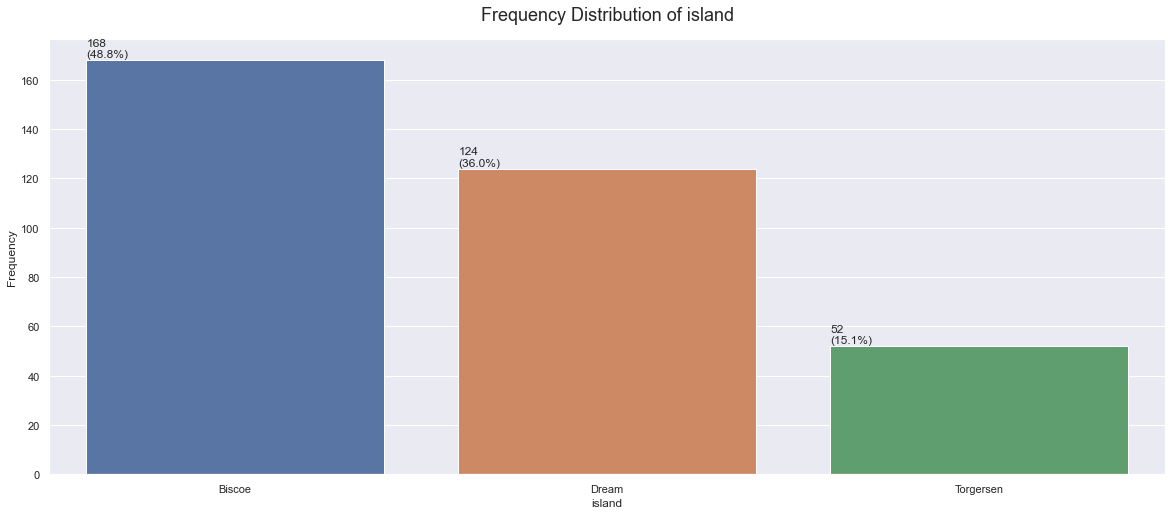

In [11]:
cat_dist(df=pen,var_name='island',plot=True,viz='Bar',cat_limit=10)

,Category,Frequency,Percentage
0,Biscoe,168,48.8%
1,Dream,124,36.0%
2,Torgersen,52,15.1%


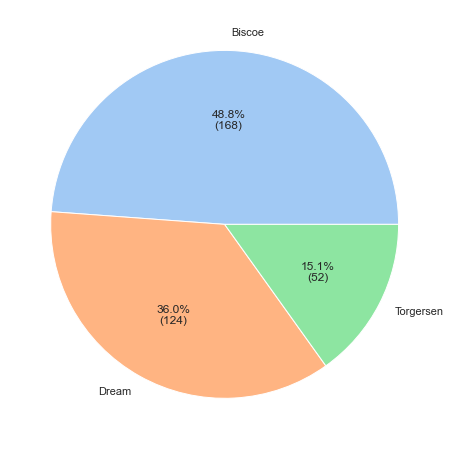

In [12]:
cat_dist(df=pen,var_name='island',plot=True,viz='Pie',cat_limit=10)

### Numerical column distribution

In [13]:
def show_distribution(df=None,variable_name='',
                      pctl = [1, 10, 20, 25, 30 , 33, 40 , 50 , 60 , 67, 70, 75, 80 , 90 , 99], 
                      plot= True, bins = 50,
                      decimals_ = 2):
    '''
    This function shows the distribution (Histogram plot) of any variable and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : String, Name of the variable for which the distribution should be shown
        pctl          : List of Percentile values that should be returned (1 to 100 in multiples of 1)
        plot          : Boolean, Default True; Will plot a histogram if set to True
        bins          : The number of bins into which the data should be plotted on the histogram
        decimals_     : # of decimals shown for the varaible
    '''
    percentil = df[variable_name].quantile(np.linspace(.01, 1, 99, 0), 'lower')
    op = percentil.to_frame().reset_index()
    op.index = op.index+1.
    op = op[op.index.isin(pctl)]
    op.rename(columns = {'index': 'Percentile'},inplace=True)
    op.loc[len(op.index)] = [0, df[variable_name].min()]
    op.loc[len(op.index)] = [1, df[variable_name].max()]
    op['Percentile'] = 'p_'+ (op['Percentile']*100).astype(int).astype(str).str.zfill(2)
    op.loc[len(op.index)] = ['AVG', df[variable_name].mean()]
    op.sort_values(by=[variable_name,'Percentile'],inplace = True)
    op.reset_index(inplace=True,drop=True)
    op[variable_name] = op[variable_name].round(decimals_)
    if plot == True:
        plt.figure(figsize = (20,8))
        sns.histplot(x=df[variable_name], bins = bins, kde= True)
    return op

,Percentile,flipper_length_mm
0,p_00,172.00
1,p_01,178.00
2,p_10,185.00
3,p_20,188.00
4,p_25,190.00
5,p_30,191.00
6,p_33,192.00
7,p_40,194.00
8,p_50,197.00
9,AVG,200.92


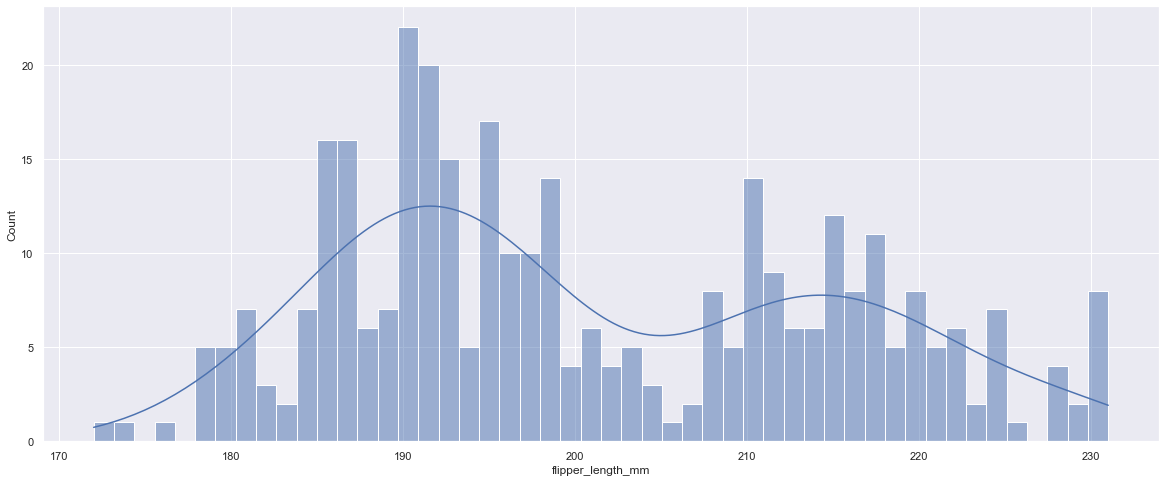

In [14]:
show_distribution(df=pen,variable_name='flipper_length_mm',)

In [15]:
def show_distribution_multi_var(df=None,variable_names=[''],
                      pctl = [1, 10, 20, 25, 30 , 33, 40 , 50 , 60 , 67, 70, 75, 80 , 90 , 99], 
                      plot = True,
                      decimals_ = 2):
    '''
    This function shows the distribution (box-plots) of a list of variables and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : List of strings, Names of the variables for which the distribution should be shown. If this is not provided, all numerical columns will be shown
        pctl          : List of Percentile values that should be returned (1 to 100 in multiples of 1)
        plot          : Boolean, Default True; Will plot a histogram if set to True
        decimals_     : # of decimals shown for the varaible
    '''
    if variable_names==['']: vars_ = df.select_dtypes(include='number').columns.values
    else: vars_ = variable_names
    list_ = []
    for v in vars_:
        percentil = df[v].quantile(np.linspace(.01, 1, 99, 0), 'lower')
        op = percentil.to_frame().reset_index()
        op.index = op.index+1.
        op = op[op.index.isin(pctl)]
        op.rename(columns = {'index': 'Percentile'},inplace=True)
        op.loc[len(op.index)] = [0, df[v].min()]
        op.loc[len(op.index)] = [1, df[v].max()]
        op['Percentile'] = 'p_'+ (op['Percentile']*100).astype(int).astype(str).str.zfill(2)
        op.loc[len(op.index)] = ['AVG', df[v].mean()]
        op.sort_values(by=[v,'Percentile'],inplace = True)
        op.reset_index(inplace=True,drop=True)
        op[v] = op[v].round(decimals_)
        list_.append(op)    
    #Box-Plots
    if plot == True:
        sns.boxplot(x="variable", y="value", data=pd.melt(df[vars_]), palette="Set3")
    from functools import reduce
    op_df = reduce(lambda df1,df2: pd.merge(df1,df2,on='Percentile'), list_)
    return op_df

,Percentile,flipper_length_mm,bill_length_mm
0,p_00,172.00,32.10
1,p_01,178.00,34.00
2,p_10,185.00,36.60
3,p_20,188.00,38.30
4,p_25,190.00,39.20
5,p_30,191.00,40.20
6,p_33,192.00,40.70
7,p_40,194.00,42.00
8,p_50,197.00,44.40
9,AVG,200.92,43.92


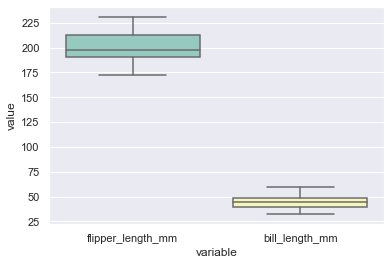

In [16]:
show_distribution_multi_var(df=pen,variable_names=['flipper_length_mm','bill_length_mm'],)

,Percentile,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,p_00,32.10,13.10,172.00,2700.00
1,p_01,34.00,13.40,178.00,2900.00
2,p_10,36.60,14.30,185.00,3300.00
3,p_20,38.30,15.00,188.00,3475.00
4,p_25,39.20,15.60,190.00,3550.00
5,p_30,40.20,15.90,191.00,3650.00
6,p_33,40.70,16.10,192.00,3700.00
7,p_40,42.00,16.80,194.00,3800.00
8,AVG,43.92,17.15,200.92,4201.75
9,p_50,44.40,17.30,197.00,4050.00


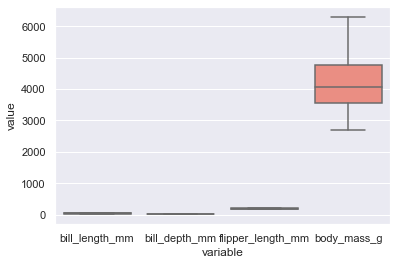

In [17]:
show_distribution_multi_var(df=pen)

In [18]:
def box_plots_univariate_by_category(df = None, numeric_var ='', categorical_var = '', categorical_var2 = '' ):
    '''
    This function creates box-plots for a single numeric variable divided by categorical variables.
    It allows for a secondary categorical variable 
    Parameters:
        df               : The dataframe which contains the data
        numeric_var      : The target numberic variable for which we are viewing the distribution
        categorical_var  : The categorical varibale by which the distribution is to be split (ideally not more than 5 categories)
        categorical_var2 : The categorical varibale by which the first category is further split (ideally not more than 3 categories)
    '''
    sns.set_style("whitegrid")
    plt.figure(figsize = (20,8))
    if categorical_var2 == '':
        ax = sns.boxplot(x=categorical_var, y=numeric_var, data=df, palette="Set2")
    else:
        ax = sns.boxplot(x=categorical_var, y=numeric_var, hue = categorical_var2, data=df, palette="Set2")

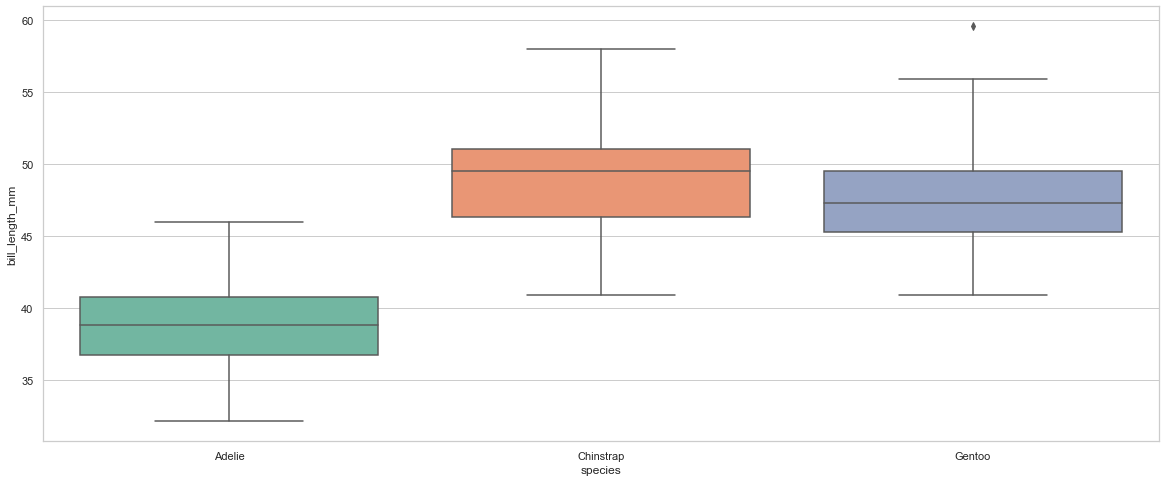

In [19]:
box_plots_univariate_by_category(pen,numeric_var='bill_length_mm',categorical_var='species',)

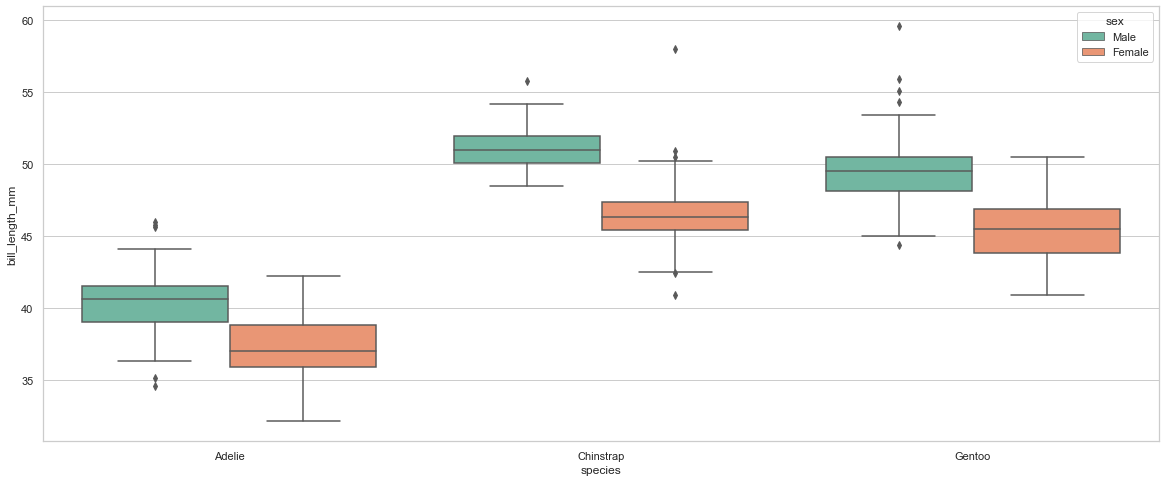

In [20]:
box_plots_univariate_by_category(pen,numeric_var='bill_length_mm',categorical_var='species', categorical_var2 = 'sex' )

### Multi-variate Exploration

In [21]:
#Function returns a correlation of all other variables with specified target variable
def target_corr (df=None,target_var='',method=None):
    '''
    Function returns correlation of the target variable with all the remaining variables
    
    Parameters:
        df : The dataframe with all variables
        target_var : Variable that you wanty to check of all other vars with passed as a string
        method : 'pearson','kendall','spearman'
    
    Returns:
        Dataframe with 
    '''
    if method == None:
        method = 'pearson' 
    corr_name = method+'corr'
    df_corr = df.corr(method)
    var_corr = df_corr[target_var].to_frame()
    var_corr.rename({target_var:corr_name},axis=1,inplace = True)
    var_corr['abs_'+corr_name] = var_corr[corr_name].abs()
    var_corr.drop(target_var,axis=0, inplace=True)
    var_corr.sort_values('abs_'+corr_name,ascending=False,inplace=True)
    return var_corr

In [22]:
target_corr (pen,target_var='bill_length_mm')

,pearsoncorr,abs_pearsoncorr
flipper_length_mm,0.656181,0.656181
body_mass_g,0.595110,0.595110
bill_depth_mm,-0.235053,0.235053


In [23]:
#Function to show correlation matrix between all variables
def corr_matrix (df=None,method=None,show_values = True, return_flag = False):
    '''
    Function returns correlation of all variables with each other
    
    Parameters:
        df          : The dataframe with all variables
        method      : 'pearson','kendall','spearman'; Default is 'pearson'
        show_values : Boolean, Default True
    
    Returns:
        Correlation Matrix dataframe, if return_flag set to True. Returns nothing by default
    '''
    if method == None:
        method = 'pearson' 
    corr_name = method+'corr'
    df_corr = df.corr(method)
    plt.figure(figsize = (12,10))
    if show_values == True: sns.heatmap(df_corr,cmap = 'coolwarm',annot=True)
    else: sns.heatmap(df_corr,cmap = 'coolwarm')
    
    if return_flag == True: return df_corr
    else : return

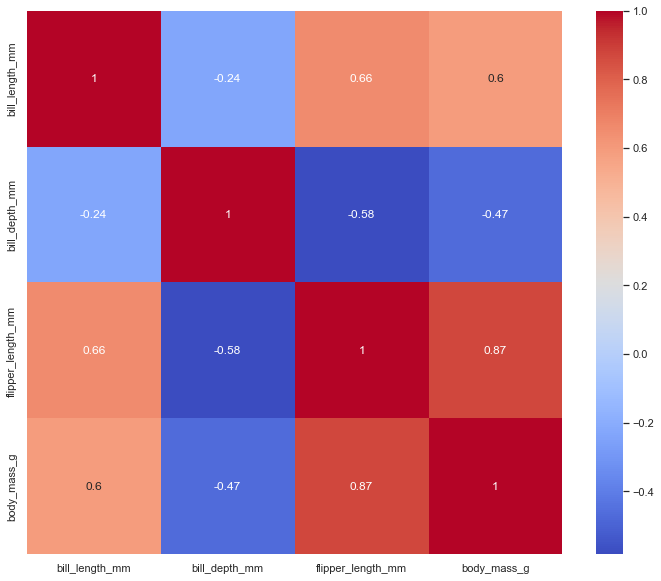

In [24]:
corr_matrix (pen,)

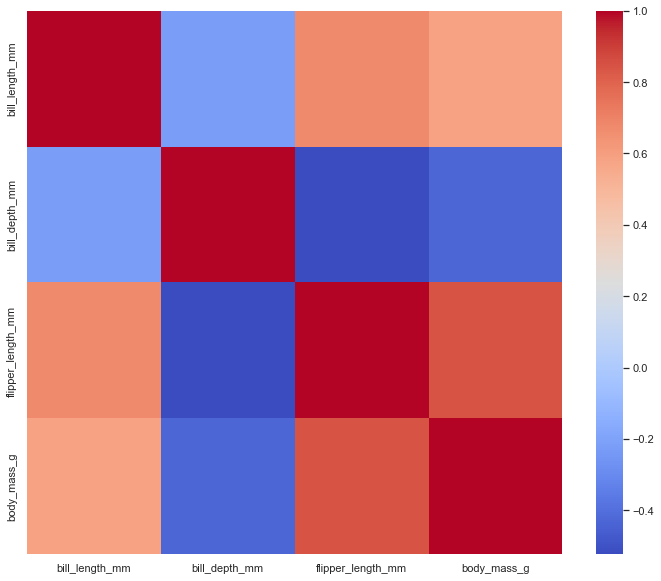

In [25]:
corr_matrix (pen,'spearman',False)